In [1]:
# Install packages
get_ipython().system('pip install torch nltk scikit-learn pandas matplotlib')


In [2]:
# 1. Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [3]:
# 3. Load dataset
df = pd.read_csv('review_20242025_standard.csv')
df = df[['review', 'sentiment']].dropna()
df.head()

review  sentiment
0  "\"The Classic War of the Worlds\" by Timothy ...          1
1  "The film starts with a manager (Nicholas Bell...          0
2  "Superbly trashy and wondrously unpretentious ...          1
3  "I dont know why people think this is such a b...          1
4  "This movie could have been very good, but com...          0

In [4]:
# 4. Text preprocessing
# Define a tokenizer that also lowercases the text
def simple_tokenizer(text):
    if isinstance(text, str):
        return re.findall(r'\b\w+\b', text.lower())
    else:
        return []



In [5]:
# 5. Tokenize text

# Apply the tokenizer directly
df['tokens'] = df['review'].apply(simple_tokenizer)

# View results
print(df[['review', 'tokens']].head())

                                              review  \
0  "\"The Classic War of the Worlds\" by Timothy ...   
1  "The film starts with a manager (Nicholas Bell...   
2  "Superbly trashy and wondrously unpretentious ...   
3  "I dont know why people think this is such a b...   
4  "This movie could have been very good, but com...   

                                              tokens  
0  [the, classic, war, of, the, worlds, by, timot...  
1  [the, film, starts, with, a, manager, nicholas...  
2  [superbly, trashy, and, wondrously, unpretenti...  
3  [i, dont, know, why, people, think, this, is, ...  
4  [this, movie, could, have, been, very, good, b...  


In [6]:
# 6. Build vocabulary from training data
from collections import Counter

all_tokens = [token for tokens in df['tokens'] for token in tokens]
word_counts = Counter(all_tokens)
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.items())}  # start from 2
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

In [7]:
# 7. Encode tokens into integers
def encode_tokens(tokens):
    return [vocab.get(token, 1) for token in tokens]  # 1 is <UNK>

df['encoded'] = df['tokens'].apply(encode_tokens)

In [8]:
# 8. Pad sequences
from torch.nn.utils.rnn import pad_sequence

max_len = 600 #0.88 的这个是600

def pad_seq(seq):
    return seq[:max_len] + [0]*(max_len - len(seq)) if len(seq) < max_len else seq[:max_len]

df['padded'] = df['encoded'].apply(pad_seq)

In [9]:
# 6. Load Pre-trained GloVe Embeddings
embedding_dim = 300
glove_path = "glove/glove.6B.300d.txt"

# Build embedding matrix
embedding_matrix = np.random.normal(0, 1, (len(vocab), embedding_dim))
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        if word in vocab:
            idx = vocab[word]
            embedding_matrix[idx] = vector


In [10]:
# 7. Create Dataset and DataLoader
class ReviewDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = torch.tensor(reviews, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.reviews[idx], self.labels[idx]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(df['padded'].tolist(), df['sentiment'].tolist(), test_size=0.2, random_state=33245215)
train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [11]:
# 8. Define CNN Model
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, embedding_weights, dropout=0.5):
        super(CNNModel, self).__init__()

        # Embedding layer with pre-trained GloVe
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_weights, dtype=torch.float32),
            freeze=False  # Allow fine-tuning
        )

        # Convolution layers with multiple filter sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=num_filters,
                      kernel_size=fs)
            for fs in filter_sizes
        ])

        # Fully connected layer
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()  # Use softmax if multi-class classification

    def forward(self, x):
        # Embedding lookup
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        embedded = embedded.permute(0, 2, 1)  # (batch_size, embedding_dim, seq_len)

        # Convolution + ReLU + Max pooling
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        pooled = [F.max_pool1d(c, c.shape[2]).squeeze(2) for c in conved]  # Global max-pooling

        # Concatenate pooled features and apply dropout
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.sigmoid(self.fc(cat))  # Use sigmoid for binary, softmax for multi-class


In [12]:
# 9. Train the CNN Model
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
embedding_dim = 300  # Match GloVe embedding dim
num_filters = 100
filter_sizes = [3, 4, 5]
output_dim = 1  # Use 1 for binary classification
dropout = 0.5
lr = 1e-3
epochs = 5

# Model instantiation
model = CNNModel(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    num_filters=num_filters,
    filter_sizes=filter_sizes,
    output_dim=output_dim,
    embedding_weights=embedding_matrix,
    dropout=dropout
).to(device)

# Loss and optimizer
criterion = nn.BCELoss()  # For binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()  # Ensure labels are float for BCELoss

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()  # Shape: (batch_size)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Accuracy calculation
        preds = (outputs >= 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {acc:.4f}")


Epoch 1/5 - Loss: 0.4373 - Accuracy: 0.7844
Epoch 2/5 - Loss: 0.2314 - Accuracy: 0.9078
Epoch 3/5 - Loss: 0.1056 - Accuracy: 0.9640
Epoch 4/5 - Loss: 0.0406 - Accuracy: 0.9885
Epoch 5/5 - Loss: 0.0151 - Accuracy: 0.9963


In [13]:
# 14. Evaluate
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze().cpu().numpy()
        preds = (outputs >= 0.5).astype(int)
        y_pred.extend(preds)
        y_true.extend(labels.numpy())


In [14]:
# 15. Report
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))


Accuracy: 0.8845
Confusion Matrix:
 [[1812  260]
 [ 228 1926]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.87      0.88      2072
         1.0       0.88      0.89      0.89      2154

    accuracy                           0.88      4226
   macro avg       0.88      0.88      0.88      4226
weighted avg       0.88      0.88      0.88      4226



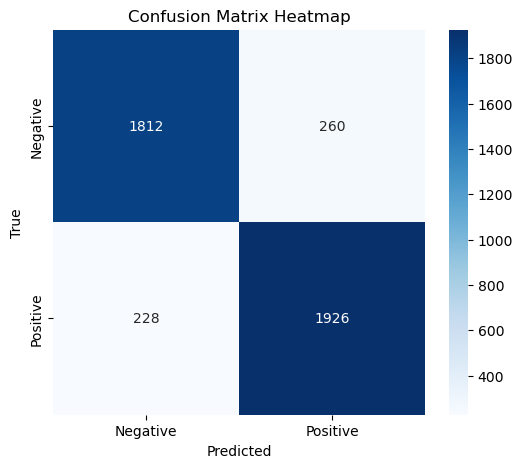

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# After collecting y_true and y_pred
cm = confusion_matrix(y_true, y_pred)

# Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities
model.eval()
y_true = []
y_scores3 = []


with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze().cpu().numpy()  # sigmoid probabilities
        y_scores3.extend(outputs)
        y_true.extend(labels.numpy())

# Compute ROC curve and AUC
fpr_3, tpr_3, thresholds = roc_curve(y_true, y_scores3)
roc_auc = auc(fpr_3, tpr_3)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_3, tpr_3, color='crimson', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

np.save("y_true_model3.npy", y_true)
np.save("y_scores_model3.npy", y_scores3)



In [17]:
# 15. Predict function for new input
def preprocess_and_encode(text, vocab):
    tokens = simple_tokenizer(text)
    encoded = encode_tokens(tokens)
    padded = pad_seq(encoded)
    return torch.tensor([padded], dtype=torch.long)

def predict_sentiment(text, model, vocab, device):
    model.eval()
    input_tensor = preprocess_and_encode(text, vocab).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        pred = int(output.item() >= 0.5)
        return "Positive" if pred == 1 else "Negative"

# Examples
print("Example 1:", predict_sentiment("This movie could have been very good", model, vocab, device))
print("Example 2:", predict_sentiment("This movie could have been very bad", model, vocab, device))

Example 1: Positive
Example 2: Negative
